In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from utils import preprocess_config
from model import DroneModel
import cv2
import pandas as pd
import numpy as np

In [2]:
config = preprocess_config(OmegaConf.load('config.yaml'))
model = DroneModel(config)
im_size = config['dataset']['img_size']
test_df_path = config['dataset']['test_csv']

Ниже нужно лишь указать путь к чекпоинту в checkpoint_path

In [5]:
checkpoint_path = 'test_exp/lightning_logs/version_0/checkpoints/best-epoch=40-val_iou=0.65.ckpt'
ckpt = torch.load(checkpoint_path, map_location='cuda:3')
model.load_state_dict(ckpt['state_dict']) 
model = model.eval()

/usr/local/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


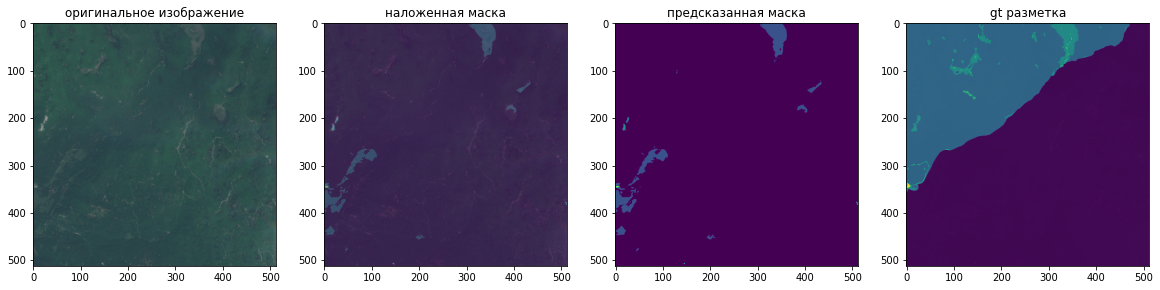

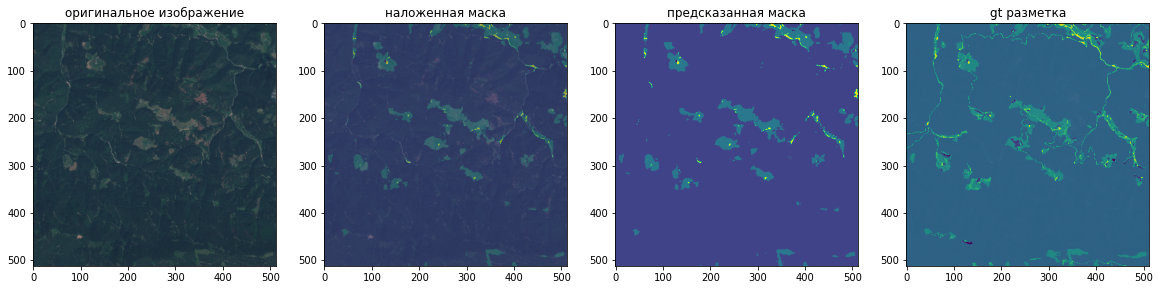

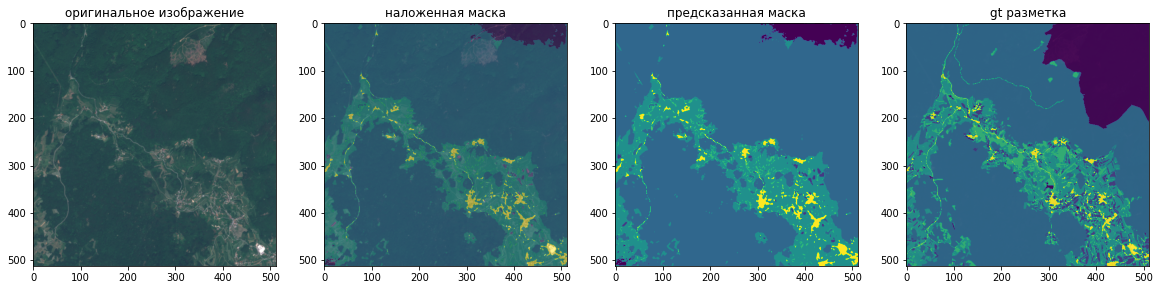

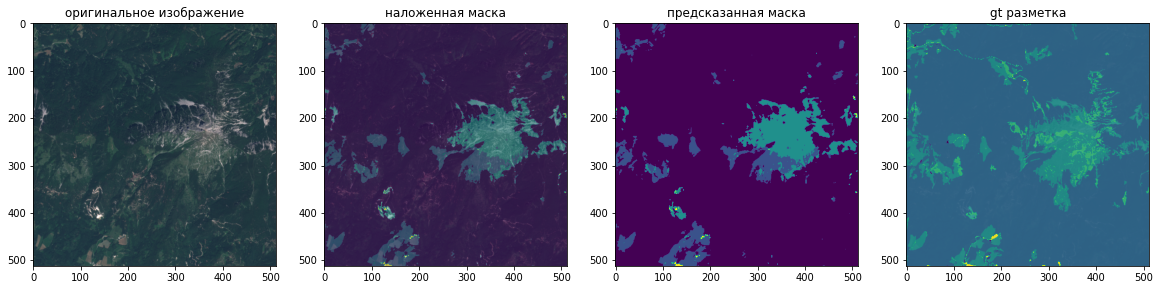

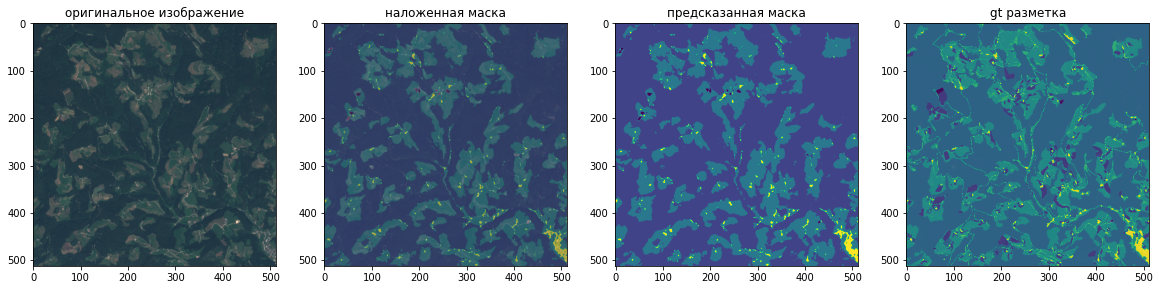

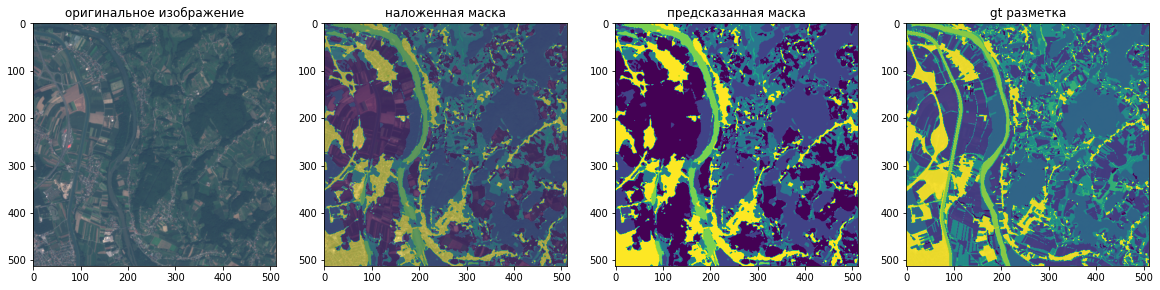

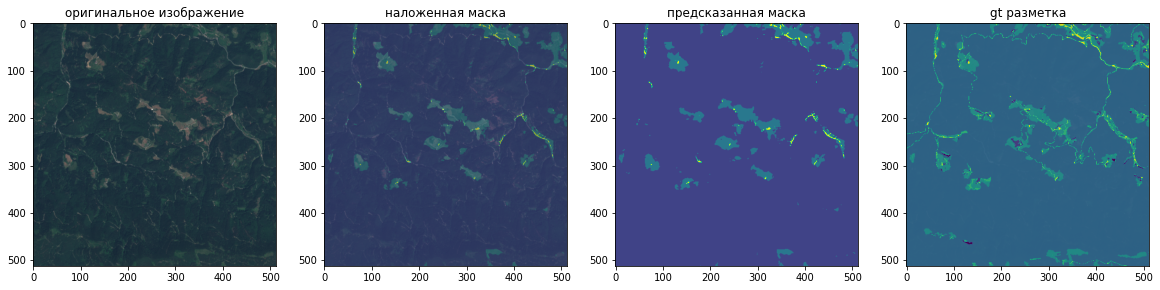

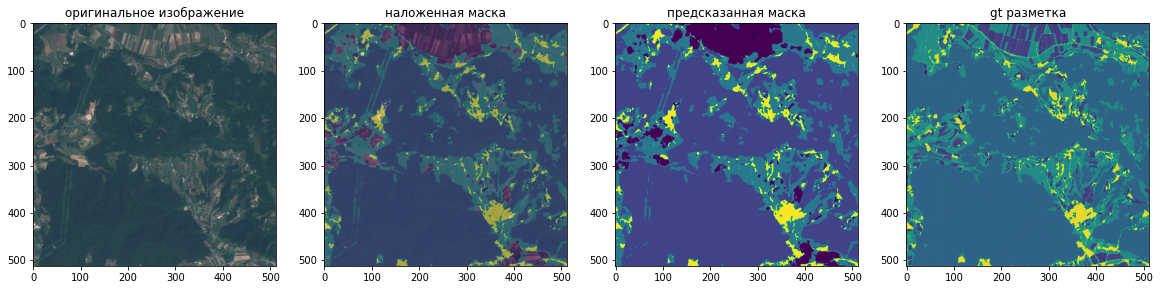

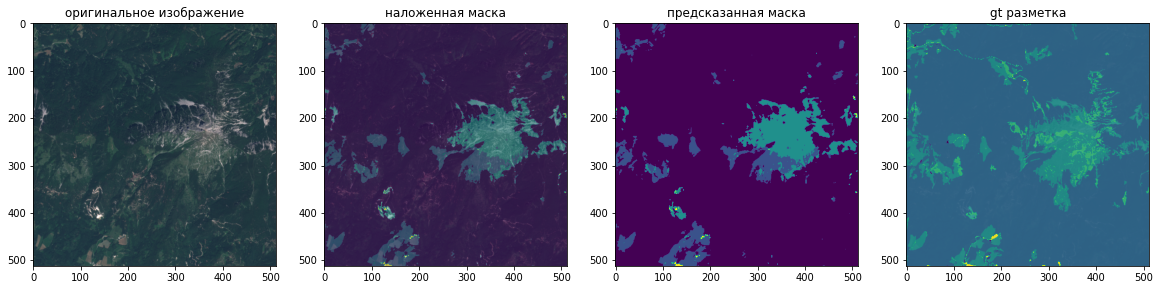

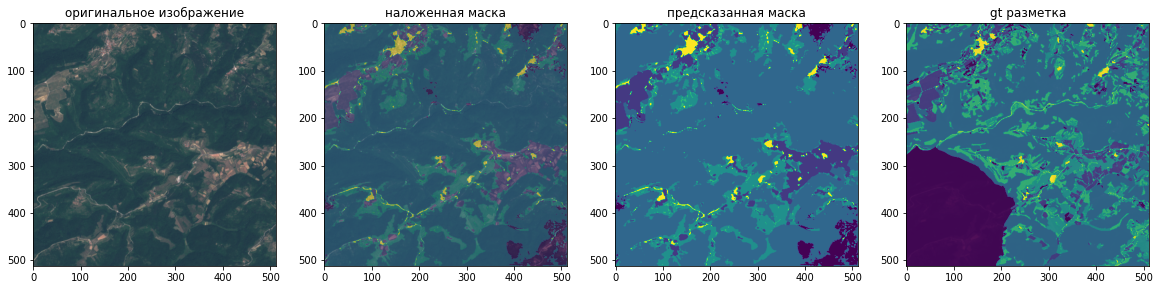

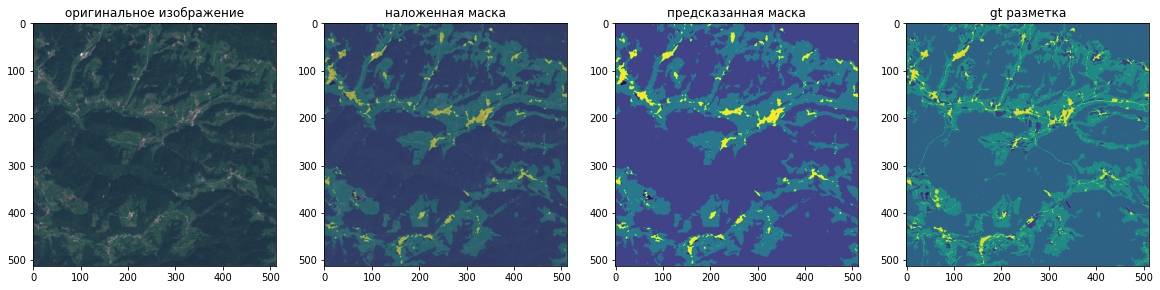

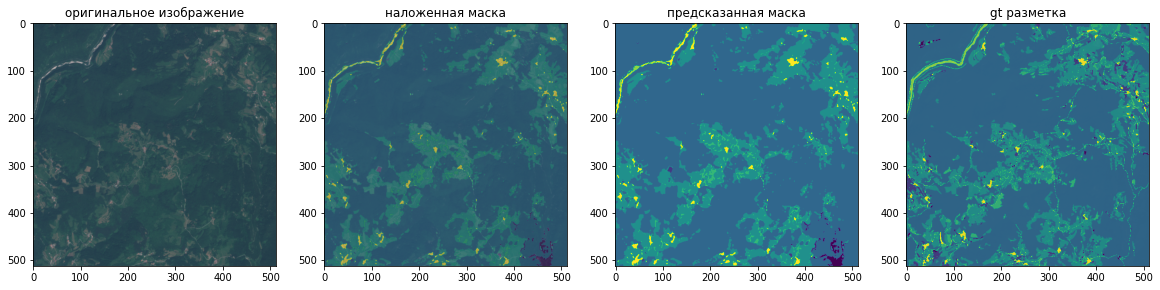

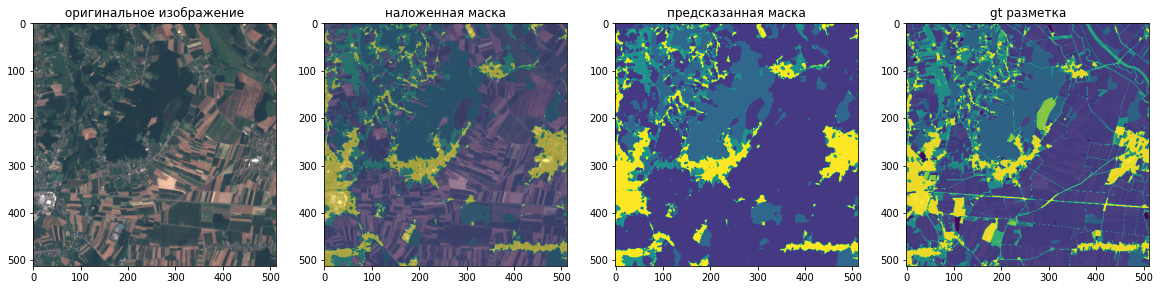

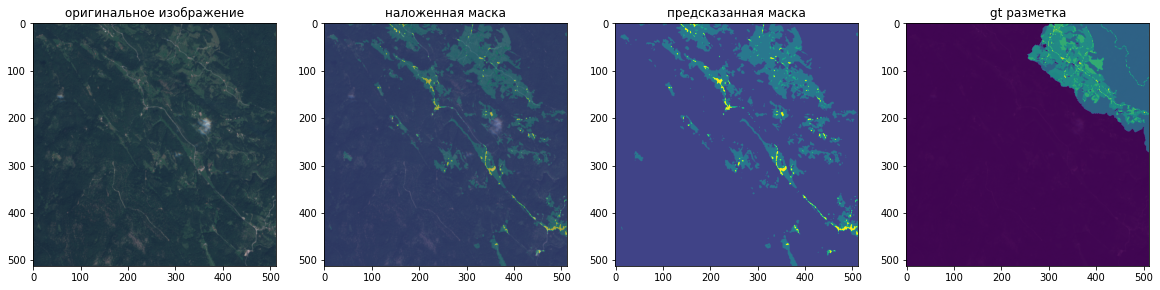

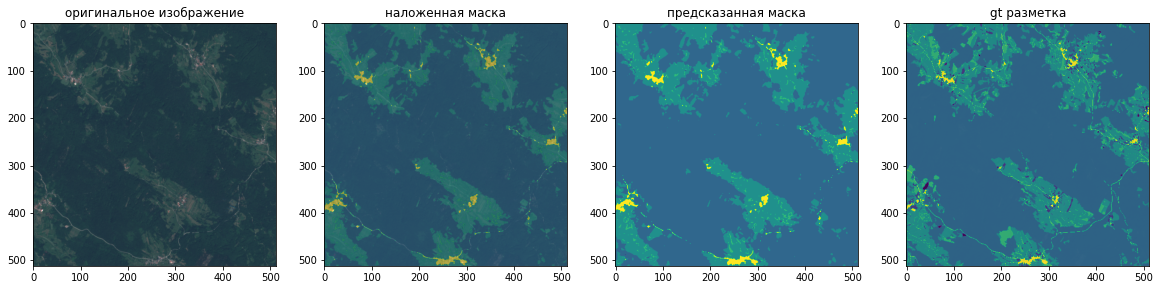

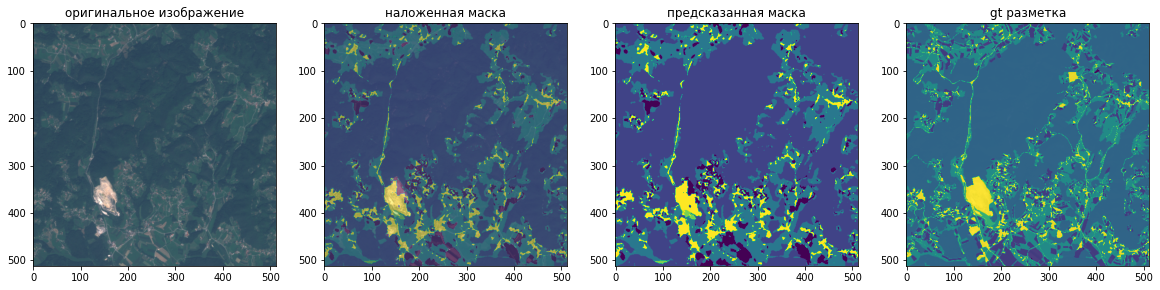

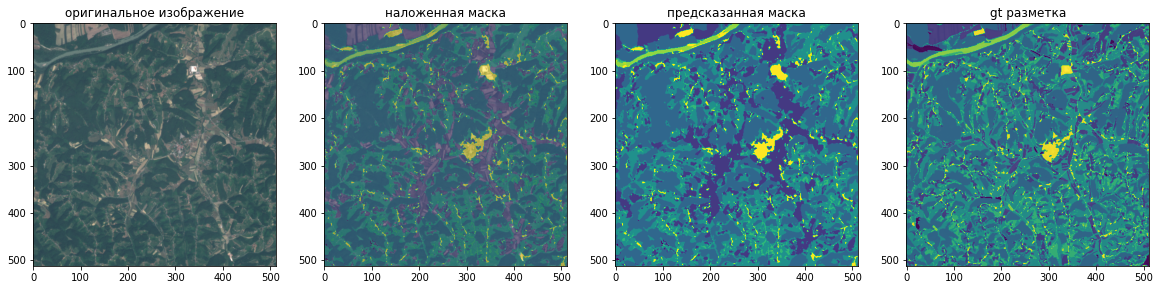

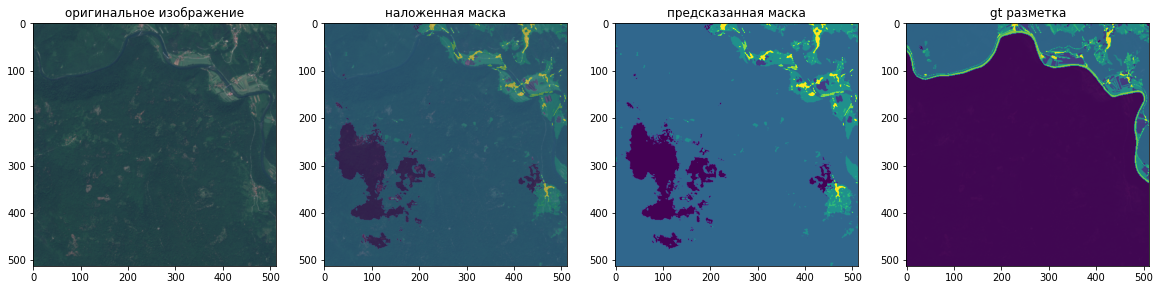

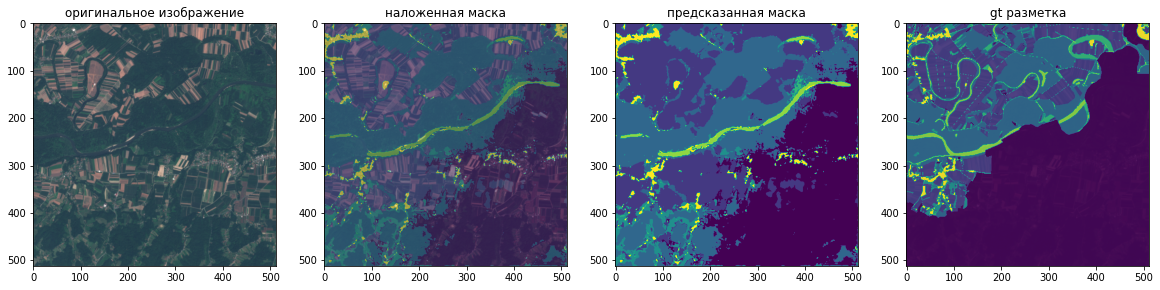

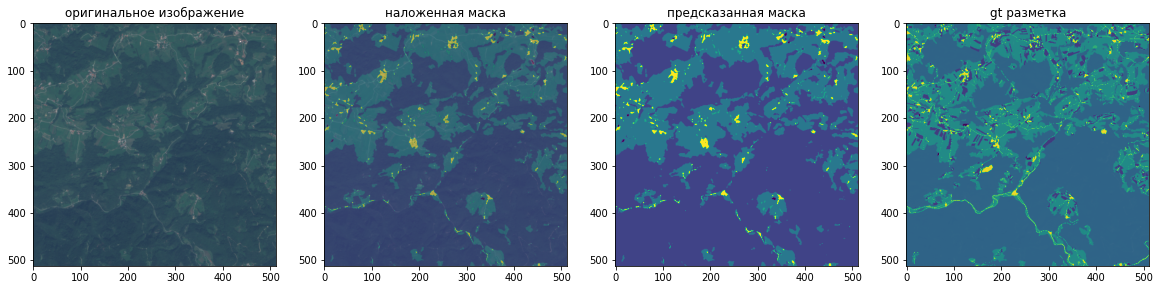

In [6]:
test_df = pd.read_csv(test_df_path)
dem_df = test_df.sample(n=20, replace=True)

for col, row in dem_df.iterrows():
    mean=np.array([0, 0, 0])
    std=np.array([1, 1, 1])

    img_path = row["image_path"]
    gt_mask_path = row["mask_path"]
    gt_mask = cv2.imread(gt_mask_path)
    gt_mask = cv2.resize(gt_mask, (im_size, im_size), interpolation=cv2.INTER_LINEAR)
    
    gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_RGB2GRAY)
    
    
    image = cv2.imread(img_path)
    image = cv2.resize(image, (im_size, im_size), interpolation=cv2.INTER_LINEAR)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    img = ((image.astype(np.float32) / 255.0 - mean) / std).astype(np.float32)

    img = torch.from_numpy(img).permute(2, 0, 1)
    
    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0))
        
    softmax = nn.Softmax() 
    proba_mask = softmax(pred_mask)
    ers_mask = torch.argmax(proba_mask, dim=1).unsqueeze(0).permute(0,2,3,1).cpu().numpy().astype(np.uint8)
    
    image = cv2.resize(image, (im_size, im_size), interpolation=cv2.INTER_LINEAR)
    pred_mask = cv2.resize(ers_mask[0], (im_size, im_size), interpolation=cv2.INTER_LINEAR)


    plt.figure(figsize=(20, 20))
    plt.subplot(1,4,1)
    plt.title('оригинальное изображение')
    plt.imshow(image)
    plt.subplot(1,4,2)
    plt.title('наложенная маска')
    plt.imshow(image)
    plt.imshow(pred_mask, alpha=0.5)
    plt.subplot(1,4,3)
    plt.title('предсказанная маска')
    plt.imshow(pred_mask)
    plt.subplot(1,4,4)
    plt.title('gt разметка')
    plt.imshow(image)
    plt.imshow(gt_mask, alpha=0.9)
    plt.show
    